<a href="https://colab.research.google.com/github/kalehariprasad/youtube_comment_sentiment_classifier/blob/main/notebooks/experiment_1_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mlflow dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.5/677.5 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
import mlflow
import dagshub

# Define your actual DagsHub username
USERNAME = "kalehariprasad"
REPO_NAME= "youtube_comment_sentiment_classifier"

# Read the PAT from the file
with open("/content/DAGSHUB_PAT.txt", "r") as f:
    DAGSHUB_PAT = f.read().strip()
# Set environment variables for MLflow authentication
os.environ["MLFLOW_TRACKING_USERNAME"] = USERNAME
os.environ["MLFLOW_TRACKING_PASSWORD"] = DAGSHUB_PAT

# Set MLflow tracking URI
mlflow.set_tracking_uri(f"https://dagshub.com/{USERNAME}/{REPO_NAME}.mlflow")

In [4]:
import numpy as np
import pandas as pd

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [6]:
df.dropna(inplace=True)

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df = df[~(df['clean_comment'].str.strip() == '')]

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [10]:
# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hariprasad\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hariprasad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
# Define the preprocessing function
def preprocess_comment(comment):
    # Convert to lowercase
    comment = comment.lower()

    # Remove trailing and leading whitespaces
    comment = comment.strip()

    # Remove newline characters
    comment = re.sub(r'\n', ' ', comment)

    # Remove non-alphanumeric characters, except punctuation
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)

    # Remove stopwords but retain important ones for sentiment analysis
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

In [12]:
# Apply the preprocessing function to the 'clean_comment' column
df['clean_comment'] = df['clean_comment'].apply(preprocess_comment)

In [13]:
df.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [14]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Step 1: Vectorize the comments using Bag of Words (CountVectorizer)
vectorizer = CountVectorizer(max_features=10000)  # Bag of Words model with a limit of 1000 features

In [16]:
X = vectorizer.fit_transform(df['clean_comment']).toarray()
y = df['category']  # Assuming 'sentiment' is the target variable (0 or 1 for binary classification)

In [17]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [18]:
X.shape

(36793, 10000)

In [19]:
y

0        1
1        1
2       -1
3        0
4        1
        ..
37244    0
37245    1
37246    0
37247    1
37248    0
Name: category, Length: 36793, dtype: int64

In [20]:
y.shape

(36793,)

In [21]:
mlflow.set_experiment("RF Baseline")

<Experiment: artifact_location='mlflow-artifacts:/fb87d3fe588b42dba413def2163d77bc', creation_time=1742488048504, experiment_id='0', last_update_time=1742488048504, lifecycle_stage='active', name='RF Baseline', tags={}>

c:\Users\Hariprasad\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Accuracy: 0.6412556053811659


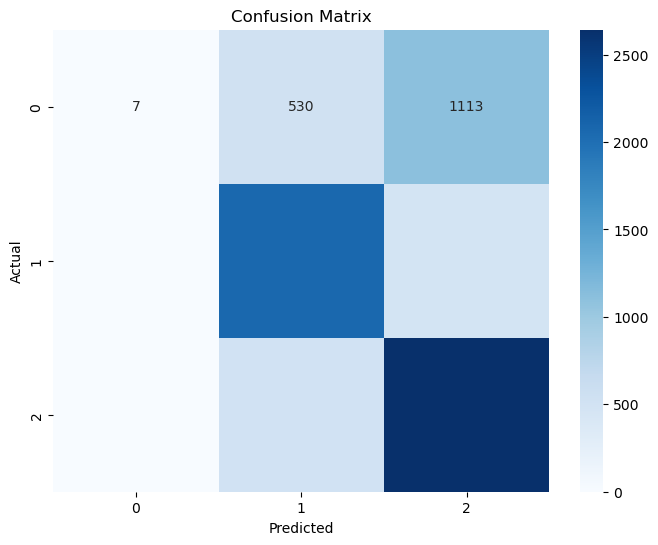

In [22]:
# Step 1: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Step 2: Define and train a Random Forest baseline model using a simple train-test split
with mlflow.start_run() as run:
    # Log a description for the run
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    # Add a description
    mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    # Log parameters for the vectorizer
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Log Random Forest parameters
    n_estimators = 200
    max_depth = 15

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Log metrics for each class and accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Log the Random Forest model
    mlflow.sklearn.log_model(model, "random_forest_model")

    # Optionally log the dataset itself (if it's small enough)
    df.to_csv("dataset.csv", index=False)
    mlflow.log_artifact("dataset.csv")

# Display final accuracy
print(f"Accuracy: {accuracy}")

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.01      0.02      1650
           0       0.68      0.81      0.74      2555
           1       0.62      0.85      0.72      3154

    accuracy                           0.65      7359
   macro avg       0.77      0.56      0.49      7359
weighted avg       0.73      0.65      0.57      7359



In [23]:

df.to_csv('reddit_preprocessing.csv', index=False)

In [26]:
pd.read_csv('reddit_preprocessing.csv').head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1
